# Uldir Guild Awards Analysis

<ul>
<li><a href="#collect">Collect Analysis Data</a></li>
<li><a href="#taloc">Taloc</a></li>
<li><a href="#mother">MOTHER</a></li>
<li><a href="#zekvoz">Zek'voz</a>
<li><a href="#vectis">Vectis</a>
<li><a href="#fetid">Fetid</a>
<li><a href="#zul">Zul</a>
<li><a href="#mythrax">Mythrax</a>
<li><a href="#ghuun">G'Huun</a>
<li><a href="#overall">Overall</a>
    <ul>
        <li><a href="#pots">Most Pots Used</a></li>
        <li><a href="#healthstone">Most Healthstones/Pots Used</a></li>
        <li><a href="#rankings">Rankings</a></li>
        <li><a href="#prog-parse">Highest Parse on Progression Kill</a></li>
    </ul></li>
</ul>

This notebook extracts information from the [Warcraft Logs](https://www.warcraftlogs.com/) API to produce data for the [Last Pull](https://tempestgorg.enjin.com/) Uldir guild awards.

## Setup

In [1]:
# Import all required libraries and modules
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import warcraft_logs_fn as wl
import log_analysis as la
import api_key
%matplotlib inline

In [2]:
# Import key
api_key = api_key.key

In [4]:
# Update player info
player_list = pd.read_csv('player_list.csv')
player_list

,player,primary_role,alt,tier_end,tier_start,start_date
0,Vaelyra,mdps,NaN,NaN,True,NaN
1,Metonymy,rdps,NaN,NaN,True,NaN
2,Brian,mdps,NaN,NaN,True,NaN
3,Petrol,rdps,NaN,NaN,True,NaN
4,Ayriea,rdps,NaN,NaN,True,NaN
5,Stradlock,rdps,NaN,NaN,True,NaN
6,Uuglei,mdps,NaN,NaN,True,NaN
7,Earrl,tank,NaN,NaN,True,NaN
8,Illestra,healer,NaN,NaN,True,NaN
9,Kamer,mdps,NaN,NaN,True,NaN


In [30]:
# Update changed names
elz_idx = player_list.query('player == "Grimbrondal"').index
player_list.at[elz_idx, 'player'] = 'Grombrindal'

# Test
player_list.query('player == "Grombrindal"')

,player,primary_role,alt,tier_end,tier_start,start_date
10,Grombrindal,mdps,Cagliostro,False,True,NaN


In [15]:
def add_alts(previous_name, new_name, player_list, update=False):
    idx = player_list[player_list.player == previous_name].index
    if update:
        player_list.at[idx, 'player'] = new_name
        player_list.at[idx, 'alt'] = previous_name
    else:
        player_list.at[idx, 'alt'] = new_name

In [17]:
# Add player alts
add_alts('Ayriea', 'Invinceble', player_list)
add_alts('Vaelyra', 'Noraela', player_list)
add_alts('Sumi', 'Brassi', player_list)

# Test
player_list

,player,primary_role,alt,tier_end,tier_start,start_date
0,Vaelyra,mdps,Noraela,NaN,True,NaN
1,Metonymy,rdps,NaN,NaN,True,NaN
2,Brian,mdps,NaN,NaN,True,NaN
3,Petrol,rdps,NaN,NaN,True,NaN
4,Ayriea,rdps,Invinceble,NaN,True,NaN
5,Stradlock,rdps,NaN,NaN,True,NaN
6,Uuglei,mdps,NaN,NaN,True,NaN
7,Earrl,tank,NaN,NaN,True,NaN
8,Illestra,healer,NaN,NaN,True,NaN
9,Kamer,mdps,NaN,NaN,True,NaN


Alts were correctly added.

In [19]:
# Add new players
new_players = pd.DataFrame([
    {'player': 'Kopyelock', 
     'primary_role': 'rdps', 
     'alt': np.nan,
     'tier_end': True,
     'tier_start': False,
     'start_date': 'Oct-16-18'}, 
    {'player': 'Velsummers', 
     'primary_role': 'healer', 
     'alt': np.nan,
     'tier_end': True,
     'tier_start': True,
     'start_date': np.nan}], 
    columns=['player', 'primary_role', 'alt', 
             'tier_end', 'tier_start', 'start_date'])

new_players

,player,primary_role,alt,tier_end,tier_start,start_date
0,Kopyelock,rdps,NaN,True,False,Oct-16-18
1,Velsummers,healer,NaN,True,True,NaN


In [22]:
# Add to player_list
player_list = pd.concat([player_list, new_players])

# Test
assert player_list.tail(2).player.isin(['Kopyelock', 'Velsummers']).sum() == 2

In [31]:
# Confirm end of tier players
end_of_tier = ['Vaelyra', 'Metonymy', 'Brian', 'Petrol', 'Ayriea', 
               'Stradlock', 'Uuglei', 'Earrl', 'Illestra', 'Grombrindal', 
               'Tawn', 'Draigo', 'Psychodruid', 'Sumi', 'Toy', 'Mythrose', 
               'Shadowbaine', 'Acturus', 'Velryssa', 'Jampers', 'Vampyric', 
               'Kopyelock', 'Velsummers']

player_list.tier_end = player_list.player.isin(end_of_tier)

# Test
assert player_list.tier_end.sum() == len(end_of_tier)

In [32]:
# Update saved player list
player_list.to_csv('player_list.csv', index=False)

In [33]:
# Collect guild info
guild_info = wl.GUILD_INFO

# Extract logs
log_info = wl.get_logs(api_key, guild_info, log_start=1536202744238)
wl.save_logs(log_info, api_key, guild_info, log_start=1536202744238)

# Create boss list
boss_list = ['Taloc', 
             'MOTHER', 
             'Fetid Devourer', 
             "Zek'voz", 
             'Vectis',
             'Zul', 
             'Mythrax', 
             "G'Huun"]

# Extract fight details and save
fight_df = wl.extract_fights(boss_list)
wl.create_master_list(log_info, fight_df)

Creating file vTWVFQfwcHztbnKL
Creating file JgqKCkP7p3nAd1Ha
Creating file GbryNmfD98zcH6Jn
Creating file Hg83cdfhJaLyp6rG
Creating file k3LJpfYV1Nv2t8zq
Creating file mPaDJCdt4rWQkA7V
Creating file PYArFRQJ9MCT6jXy
Creating file rTPDJGpVXFZwNkA7
Creating file 9t1JjYfvbZkyWCGP
Creating file ac1rQnYvZWRjypVD
Creating file rMPLdKwCcH78Yz9q
Creating file 1rnktHXvcTWD2JzL
Creating file 96XVRq3ZJ2pGk1YC
Creating file FGhKD9AmjVpRMYw2
Creating file jaqf6V3Q4vNmDFdR
Creating file d3P97v4DpLHmyZkW
Creating file 6JMd2cmzFk8Qa1gj
Creating file ArqaVzbYtW7BG2Cx
Creating file 81HkLmCMRdAg6rNJ
Creating file nxf6krQP8Bvty9V2
Creating file V8Nd6ntR4PZMmLQW
Creating file VkQfpqZHB419zDcr
Creating file GdR1r6pVwA9TWXbJ
Creating file gcfCXbY14qDyhZtv
Creating file agwcpfjKbLTHrd1W
Creating file nqKDNkYjg9hzTwL6
Creating file T7xMvwtyG9YaP6k3
Creating file DycbAK6f1PL7Wpkd
Creating file rVcMgwvmPfDHYZ1a
Creating file VJQh2mdxkYypc196

All files created.

Log ID 1rnktHXvcTWD2JzL done.
Log ID 4mzCD2x9hnqZ

In [34]:
# Check all players added
fight_df.player_name.unique()

array(['Petrol', 'Illestra', 'Tawn', 'Liavre', 'Shadowbaine', 'Metonymy',
       'Draigo', 'Psychodruid', 'Kopyelock', 'Mythrose', 'Brian', 'Sumi',
       'Vaelyra', 'Katanescence', 'Acturus', 'Toy', 'Ayriea', 'Jampers',
       'Earrl', 'Grombrindal', 'Velryssa', 'Vampyric', 'Cagliostro',
       'Dough', 'Stradlock', 'Uuglei', 'Kiwisoda', 'Noraela', 'Katheals',
       'Invinceble', 'Brassi', 'Humanraptor', 'Czef', 'Quasilloyd',
       'Oakinon', 'Heavenlylite'], dtype=object)

Missing two player adds: 
1. Kiwisoda as main
2. Katheals as alt

In [35]:
add_alts('Katanescence', 'Katheals', player_list)

new_players = pd.DataFrame([
    {'player': 'Kiwisoda', 
     'primary_role': 'rdps', 
     'alt': np.nan,
     'tier_end': True,
     'tier_start': False,
     'start_date': 'Oct-23-18'}], 
    columns=['player', 'primary_role', 'alt', 
             'tier_end', 'tier_start', 'start_date'])

player_list = pd.concat([player_list, new_players])

# Test
assert player_list.alt.count() == 5
assert player_list.shape[0] == 28

In [36]:
# Update player list
player_list.to_csv('player_list.csv', index=False)

<a id='collect'></a>
## Collect Analysis Data

In [2]:
# Import key and player list
api_key = api_key.key
player_list = pd.read_csv('player_list.csv')

# Collect guild info
guild_info = wl.GUILD_INFO

# Extract logs
log_info = wl.get_logs(api_key, guild_info, log_start=1536202744238)
wl.save_logs(log_info, api_key, guild_info, log_start=1536202744238)

# Create boss list
boss_list = ['Taloc', 
             'MOTHER', 
             'Fetid Devourer', 
             "Zek'voz", 
             'Vectis',
             'Zul', 
             'Mythrax', 
             "G'Huun"]

# Extract fight details and save
fight_df = wl.extract_fights(boss_list)
wl.create_master_list(log_info, fight_df)

master_list = pd.read_csv('master_list.csv')
master_list = master_list[master_list.difficulty == 5] # Get mythic only

# Set formatting
sns.set()
sns.set_style('white')
palette=['#dcb950', '#55a868', '#dd8452', '#4c72b0', '#7fb3e6']


All files created.

Log ID 1rnktHXvcTWD2JzL done.
Log ID 4mzCD2x9hnqZb3KG done.
Log ID 4zpRXjQA3Fhg9KdJ done.
Log ID 6JMd2cmzFk8Qa1gj done.
Log ID 81HkLmCMRdAg6rNJ done.
Log ID 96XVRq3ZJ2pGk1YC done.
Log ID 9t1JjYfvbZkyWCGP done.
Log ID ac1rQnYvZWRjypVD done.
Log ID agwcpfjKbLTHrd1W done.
Log ID ArqaVzbYtW7BG2Cx done.
Log ID ArVhTvdPmLf9JHjR done.
Log ID bKHF3fdQCJqGZzPt done.
Log ID d3P97v4DpLHmyZkW done.
Log ID dgkHRTaMQGJ7Zm3C done.
Log ID dHMk9Czm4GWRF8Tx done.
Log ID dV3RWaQchfv9zT64 done.
Log ID DycbAK6f1PL7Wpkd done.
Log ID FGhKD9AmjVpRMYw2 done.
Log ID fK7dCTJBknH64Xpz done.
Log ID FQwrJhRb2dypT6PC done.
Log ID GbryNmfD98zcH6Jn done.
Log ID gcfCXbY14qDyhZtv done.
Log ID GdR1r6pVwA9TWXbJ done.
Log ID Hg83cdfhJaLyp6rG done.
Log ID HQBfXNr6kqhP4dm1 done.
Log ID jaqf6V3Q4vNmDFdR done.
Log ID Jd2kb7C9PncfqN1v done.
Log ID JgqKCkP7p3nAd1Ha done.
Log ID JTrPMkjvCH6NtR7x done.
Log ID k3LJpfYV1Nv2t8zq done.
Log ID kgfWrMTP93417Yja done.
Log ID kKrTnBRXgtW3aJHw done.
Log ID KmVAr4DMhcvF

In [9]:
# Confirm boss IDs
boss_info = ['boss_id', 'boss_name']
master_list.drop_duplicates(subset=boss_info)[boss_info]

,boss_id,boss_name
0,2135,Mythrax
497,2136,Zek'voz
877,2128,Fetid Devourer
1077,2145,Zul
2136,2144,Taloc
2156,2141,MOTHER
2196,2134,Vectis


<a id='taloc'></a>
## Taloc

Blood Storm: 270290

In [3]:
# Damage done by Blood Storm
taloc = wl.damage_taken(api_key, master_list, 270290, boss_id=2144, hit_type='tickCount')
taloc.head()

Player added: Stradlock
Player added: Psychodruid
Player added: Metonymy
Player added: Ayriea
Player added: Katanescence
Player added: Kopyelock
Player added: Brian
Player added: Vampyric
Player added: Toy
Player added: Petrol
Player added: Acturus
Player added: Jampers
Player added: Draigo
Player added: Liavre
Player added: Velryssa
Player added: Earrl
Player added: Uuglei
Player added: Kiwisoda
Player added: Grombrindal
Player added: Shadowbaine
Player added: Cagliostro
Player added: Liavre
Player added: Earrl
Player added: Draigo
Player added: Jampers
Player added: Toy
Player added: Metonymy
Player added: Velryssa
Player added: Uuglei
Player added: Psychodruid
Player added: Stradlock
Player added: Mythrose
Player added: Petrol
Player added: Vampyric
Player added: Tawn
Player added: Shadowbaine
Player added: Ayriea
Player added: Brian
Player added: Acturus
Player added: Sumi
Player added: Vaelyra
Player added: Illestra
Player added: Katanescence
Player added: Liavre
Player added: Uug

,log_id,spell_id,player,hits,damage_taken
0,ArqaVzbYtW7BG2Cx,270290,Stradlock,5,109541
1,ArqaVzbYtW7BG2Cx,270290,Psychodruid,9,196013
2,ArqaVzbYtW7BG2Cx,270290,Metonymy,7,153565
3,ArqaVzbYtW7BG2Cx,270290,Ayriea,6,131141
4,ArqaVzbYtW7BG2Cx,270290,Katanescence,14,314003


In [4]:
# Save info
taloc.to_csv('guild_awards/taloc_bloodstorm_data.csv', index=False)
# Complete analysis
bloodstorm = la.clean_fight_count(taloc, master_list, player_list, 2144, ['hits', 'damage_taken'])
damage_taken = la.find_count_order(bloodstorm, 5, 'hits')
damage_taken

,player,hits,damage_taken,fight_count,primary_role,av_count
20,Tawn,24,512953,13,rdps,1.846154
17,Shadowbaine,39,838239,16,rdps,2.437500
8,Jampers,42,889103,15,healer,2.800000
1,Ayriea,37,808742,13,rdps,2.846154
19,Sumi,28,626483,8,rdps,3.500000
15,Petrol,67,1414053,17,rdps,3.941176
18,Stradlock,52,1070448,13,rdps,4.000000
3,Dough,42,923870,10,rdps,4.200000
13,Metonymy,79,1651819,15,rdps,5.266667
7,Illestra,85,1714369,16,healer,5.312500


In [5]:
# Save data
damage_taken.to_csv('guild_awards/taloc_bloodstorm_hits.csv', index=False)

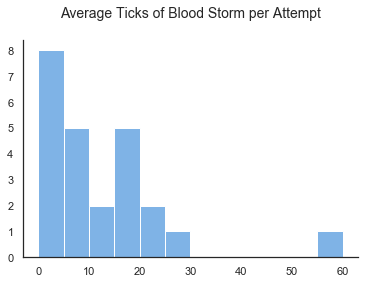

In [58]:
bins=np.arange(0, damage_taken.av_count.max() + 5, 5)
plt.hist(damage_taken.av_count, bins=bins, align='mid', color=palette[-1], edgecolor='white')
plt.title('Average Ticks of Blood Storm per Attempt\n', fontsize=14);
sns.despine()

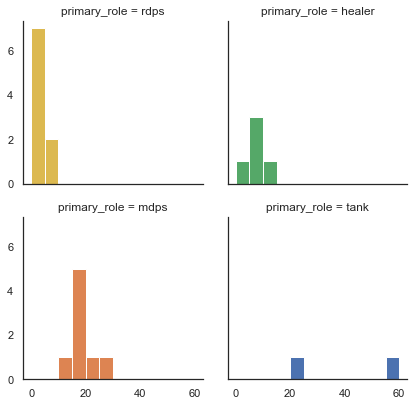

In [53]:
g = sns.FacetGrid(damage_taken, col='primary_role', hue='primary_role', 
                  col_wrap=2, palette=palette)
g.map(plt.hist, "av_count", bins=bins, align='mid', edgecolor='white');
for i in np.arange(2,4):
    g.axes[i].set_xlabel('');

In [59]:
print(damage_taken.av_count.mean())
print(damage_taken.av_count.median())

12.475472240178123
7.219230769230769


In [60]:
damage_taken.fight_count.max()

17